# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Курсовой проект

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.

На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.

Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

In [62]:
# !pip install opencv-python
# !pip install facenet_pytorch
# !pip install pyautogui

In [63]:
import os
import shutil
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from torch.autograd import Variable
from PIL import Image
from pylab import *
import cv2
from facenet_pytorch import MTCNN
import pyautogui
import webbrowser

%matplotlib inline

In [3]:
data_dir = 'images/gestures'
screen_data_dir = 'images/screen'

Перенес файлов папку test

In [4]:
# trainfiles = []
# for root, dirs, files in os.walk(data_dir, topdown = False):
#     for file in files:
#         trainfiles.append(os.path.join(root, file).replace('\\', '/'))

In [5]:
# len(trainfiles)

In [6]:
# testfiles = np.random.choice(trainfiles, size=350, replace=False)

In [7]:
# len(testfiles)

In [8]:
# for full_filename in testfiles:
#     filename = full_filename.split('/')[-1]
#     shutil.move(full_filename, filename.replace('train', 'test'))

Воспроизводим все шаги с 5-го урока для обучения модели на другом дата сете

__Подготовка данных__

In [9]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [10]:
print(os.listdir(data_dir))

['test', 'train']


In [11]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['Background', 'Edge', 'Hand', 'Mitt', 'Ok', 'V']
test Classes - ['Background', 'Edge', 'Hand', 'Mitt', 'Ok', 'V']


In [66]:
digit_to_classname = {0:'Background', 
                      1:'Edge', 
                      2:'Hand', 
                      3:'Mitt', 
                      4:'Ok', 
                      5:'V'}

In [13]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [14]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1800
    Root location: images/gestures/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               ToTensor()
           )

In [15]:
batch_size = 100

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 62, 62])


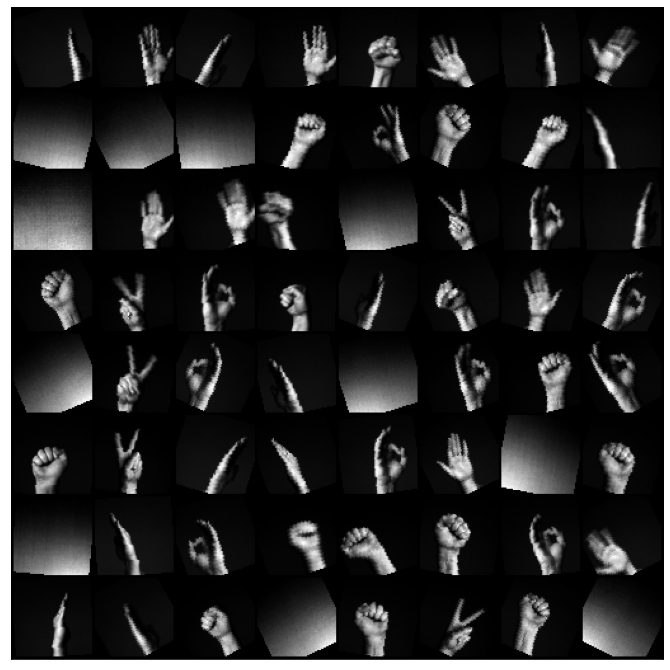

In [18]:
show_batch(train_dataloader)

In [19]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

__Создание модели__

In [22]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [23]:
model = to_device(ResNet(1, len(classes_train)), device)

__Обучение__

In [24]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 50
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [25]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

50 epochs, 18 total_steps per epoch


In [26]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

1.6.0


In [27]:
epoch_losses = []
for epoch in range(epochs):
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  1.801773241824574
Epoch 2, loss:  0.30117740978797275
Epoch 3, loss:  0.15572484417094123
Epoch 4, loss:  0.07612333384652932
Epoch 5, loss:  0.037889686620069876
Epoch 6, loss:  0.045887552874369755
Epoch 7, loss:  0.0786009985798349
Epoch 8, loss:  0.09383846922881073
Epoch 9, loss:  0.3579517547041178
Epoch 10, loss:  0.43679758063000107
Epoch 11, loss:  0.13660682489474615
Epoch 12, loss:  0.03120341644777606
Epoch 13, loss:  0.011843826949997392
Epoch 14, loss:  0.012744474480213184
Epoch 15, loss:  0.059243885835813775
Epoch 16, loss:  0.020669933429518197
Epoch 17, loss:  0.007826014487565973
Epoch 18, loss:  0.014392124822835386
Epoch 19, loss:  0.007548978348495439
Epoch 20, loss:  0.011003680346119735
Epoch 21, loss:  0.00644479394031805
Epoch 22, loss:  0.0055472657194412835
Epoch 23, loss:  0.00923115592053768
Epoch 24, loss:  0.0025532317611375926
Epoch 25, loss:  0.006010991163040874
Epoch 26, loss:  0.010728962397681445
Epoch 27, loss:  0.0113428742657156

Text(0.5, 1.0, 'losses vs. No. of epochs')

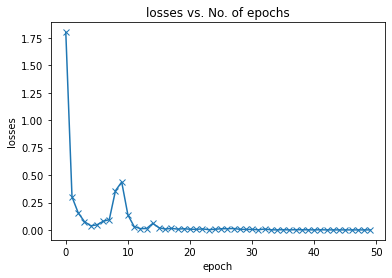

In [28]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [29]:
torch.save(model.state_dict(), 'models/gestures_detection_model_state_50_epoch.pth')

__Результаты__

In [30]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('models/gestures_detection_model_state_50_epoch.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


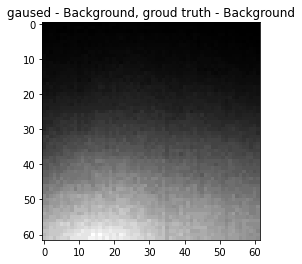

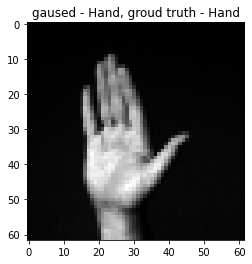

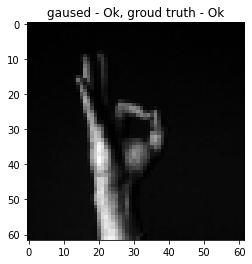

In [67]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {digit_to_classname[int(outputs[0].argmax())]}, groud truth - {digit_to_classname[int(labels[0])]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

__Приложение__

In [64]:
# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)  

# Класс детектирования и обработки руки с веб-камеры 
class HandDetector(object):

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # self.model = ResNet(1, 6).to(self.device)
        self.model = to_device(ResNet(1, 6), self.device)
        self.model.load_state_dict(torch.load('models/gestures_detection_model_state_50_epoch.pth'))
        self.model.eval()
        # Накопленные фоны
        self.bg = None
        # вес для скользящего среднего.
        self.aWeight = 0.5
        # Количество агрегируемых кадров.
        self.num_frames = 0
        # Координаты прямоугольника области определения руки.
        self.top, self.right, self.bottom, self.left = 10, 10, 300, 300
        self.counter = 0
        self.exit = False


    def run_avg(self, image):
        # Аккумулируем изображения для вычисления скользящего среднего по фону.
        if self.bg is None:
            self.bg = image.copy().astype("float")
            return

        # Накапливаем фоны
        cv2.accumulateWeighted(image, self.bg, self.aWeight)


    def segment(self, image, threshold=25):
        # Сегментируем область руки.
        try:
            diff = cv2.absdiff(self.bg.astype("uint8"), image)
            thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]
            return thresholded.sum().sum()
        except:
            print('Ошибка определения руки в области определения руки')

        
    # Функция рисования найденных параметров на кадре.
    def _draw(self, frame, boxes, probs, landmarks, gesture):
        # Отрисовка
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре.
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]),(0, 0, 255), thickness=2)
                # Рисуем обрамляющий прямоугольник области определения руки.
                # Отображаем всегда, чтобы было видно где показывать команду.
                cv2.rectangle(frame, (self.left, self.top), (self.right, self.bottom),(0, 0, 255), thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, gesture, (self.right + 5, self.bottom - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Что-то не так с функцией рисования!')

        return frame


    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        # Покропили лицо
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces


    @staticmethod
    def digit_to_classname(digit):
        if digit == 1:
            return 'Taking a screenshot'
        elif digit == 2:
            return 'Hi!'
        elif digit == 3:
            return 'Bye-Bye!'
        elif digit == 4:
            return 'Let\'s go home'
        elif digit == 5:
            return 'Attention bird!'
        else:
            return ''


    def command(self, digit, frame):
        path = 'C:/Users/be/source/repos/GeekBrains/PyTorchForANN/images/screen'
        if digit == 1:
            screen = pyautogui.screenshot()
            screen = cv2.cvtColor(np.array(screen), cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(path , f'screen_{self.counter}.png'), screen)
            self.counter += 1
        elif digit == 2:
            pass
        elif digit == 3:
            self.exit = True
        elif digit == 4:
            webbrowser.open_new_tab('https://github.com/superbe/PyTorchForANN/blob/main/%D1%81ourse%20project.ipynb')
        elif digit == 5:
            cv2.imwrite(os.path.join(path , f'mySelf_{self.counter}.png'), frame)
            self.counter += 1
        else:
            pass
        
        
    def get_hand_frame(self, frame):
        # Получить изображение области определения руки
        roi = frame[self.top:self.bottom, self.right:self.left]
        return cv2.GaussianBlur(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), (7, 7), 0)

        
    def detecte(self, frame):
        # Детектировали руку.
        self.num_frames += 1
        gray = self.get_hand_frame(frame)
        if self.num_frames < 30:
            self.run_avg(gray)
            return False
        else:
            return self.segment(gray)


    def save_image_by_train(self, hand):
        # Сохранили изображение руки для теста.
        if self.counter < 550:
            path = 'C:/Users/be/source/repos/GeekBrains/PyTorchForANN/images/screen'
            cv2.imwrite(os.path.join(path, f'{self.counter}.png'), hand)
            self.counter += 1
            if self.counter % 50 == 0:
                print(self.counter)
        else:
            print('Всё!')


    def tune(self, frame):
        # Протуюнить изображение
        hand_frame = self.get_hand_frame(frame)
        hand = cv2.resize(hand_frame,(62,62))
        
        hand_flatten = hand.flatten()
        hand_flatten_min = hand.flatten().min()
        hand_flatten_max = hand.flatten().max()
        
        for i in range(62):
            for j in range(62):
                hand[i][j] = 255.0 * (hand[i][j] - hand_flatten_min) / (hand_flatten_max - hand_flatten_min)
                if hand[i][j] < 0:
                    hand[i][j] = 0.0
                if hand[i][j] > 255:
                    hand[i][j] = 255.0
                hand[i][j] = 255.0 * (hand[i][j] / 255.0)**2
        # Заскринили изображения для подготовки набора данных.
        # self.save_image_by_train(hand)
        return hand
    
    def normalize(self, hand):
        hand_flatten = hand.flatten()
        hand_flatten_min = hand.flatten().min()
        hand_flatten_max = hand.flatten().max()
        for i in range(62):
            for j in range(62):
                hand[i][j] = hand[i][j] / 255
        return hand

        
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face,(48,48))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                gesture = ''
                
                if self.detecte(frame) > 0:
                    hand = self.tune(frame)
                    cv2.imshow("Thesholded", hand)
                    torch_hand = torch.from_numpy(self.normalize(hand.astype(float))).unsqueeze(0).to(self.device).float()
                    # Загужаем наш тензор руки в нейронную сеть и получаем предсказание
                    gesture = self.model(torch_hand[None, ...])
                    # Интерпретируем предсказание как строку нашей эмоции
                    index = gesture.argmax()
                    gesture = self.digit_to_classname(index)
                    self.command(index, frame)

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks, gesture)
                if self.exit:
                    break

            except:
                print('Что-то не так в основном цикле!')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        
# Загружаем мтцнн
mtcnn = MTCNN()
# Создаем объект нашего класса приложения
fcd = HandDetector(mtcnn)
# Запускаем
fcd.run()

Команды:
    1. Hand (рука) — вывести приветствие
    2. Mitt (кулак) — закрыть приложение
    3. Ok (очко) — перейти на этот блокнотик в Github
    4. V (коза) — сделать селфи
    5. Edge (ребро ладони) — сделать снимок экрана
    6. Background (фон) — объект заглушка на тот случай, если что-то не надо распознать.